## Testing the New AlphaEarth Foundations Satellite Embedding Dataset for Detailed Land Use Land Cover Classification
This script contain the classification process of Detailed Land Use Land Cover, while implementing SNI Classification scheme. This script use Google Earth Engine Python API, which were process entirely on cloud computing platform. The training data is created using visual interpretation, assisted with Indonesia Topographical Map
This script is organized as follows:
1. Library Import and platform preparation
2. Data Preparation
3. Parameter Optimization
4. Classification
5. Model Evaluation

**1. Importing the Necessary Library and credentials**

In [2]:
# import the library
import ee
import geemap
from geemap import ee_export_image_collection_to_drive
import numpy as np
import matplotlib as plt
import pandas as pd
import matplotlib.pyplot as plt
from gee_utils import get_sat_embedding, extract_pixel_value, rf_tuning
# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

**2. Data Preparation**
1. Define the area of interest (AOI)
2. Use *get_sat_embedding* function from *gee_utils.py* to filtered, and clip the dataset
3. Mosaic the images, since the area of interest is covered by two time periods (2023-2024 and 2024- 2025)

In [3]:
#example of Area of Interest 
aoi = ee.FeatureCollection('projects/ee-agilakbar/assets/AOI_Garsel_L9')
# Get embeddings for two different periods
image_2024 = get_sat_embedding(aoi, 2024, 2025)
#add visualization parameter
vis_params = {'min': -0.3, 'max': 0.3, 
              'bands': ['A01', 'A16', 'A09']}

***2.1 Visualize the satellite embedding data***

In [4]:
# Adding Basemap
m = geemap.Map()
# set center of the map in the area of interest
m.centerObject(aoi, 10)
# adding the data
m.addLayer(image_2024, vis_params, 'Mosaic_embedd_2023-2024')
m

Map(center=[-7.500685301245826, 107.75130712444813], controls=(WidgetControl(options=['position', 'transparent…

***2.2 Defined the region of interest (ROI)***
<br>
1. The roi is created using visual interpretation using Landsat collection data, containing 21 Land Cover and Land
Use classes, based on Indonesia's official classification system (SNI)
2. Partitioned the original ROI into training and testing data using ***extract_pixel_value*** function. The partitioning process implement random partitioned with 60% allocated as training data and 40% as testing data


In [5]:
# defining the training data
labeled_roi = ee.FeatureCollection('projects/ee-agilakbar/assets/LULC_Training_data_Garsel_project')
# partitioned the ROI into training and testing data, then extract the pixel values (sample regions)
train_samples, test_samples = extract_pixel_value(
    image=image_2024,
    roi=labeled_roi,
    class_property='LUCID',
    scale=10,
    split_ratio=0.7,
    tile_scale=16
)

**3. Parameter Optimization**
<br>
Since google earth engine did not have built-in parameter optimization, manual testing of the parameters is conducted. The SMILE Random Forest classifier is implemented, in which three primary parameters is tested, namely number of estimator (n_trees), number of variable selected per split (var_split), and minimum leaf population (min_leaf_pop)

In [20]:
#Parameter space
num_trees = [100, 200, 300]
var_split = [1,2,3,8,11,15]
min_leaf_pop = [1,2,3, 5, 9, 11]
#apply the function
results_rf = rf_tuning(
    train=train_samples, #Training data, with pixel value
    test=test_samples, #testingd data with pixel value
    band_names=image_2024.bandNames(), #band names 
    class_property='LUCID', #class labels
    n_tree_list=num_trees, #tree parameter space
    var_split_list=var_split, #variable split space
    min_leaf_pop_list=min_leaf_pop #minimum leaf pop space
)

Time increase if three parameter were used, fast classification is achieved when two parameter only used

***3.1 Inspect the best parameters***

In [22]:
#convert the result into panda data frame
df_rf = pd.DataFrame(results_rf)
df_rf = df_rf.sort_values(by='accuracy', ascending=False)
print(df_rf.head())
#get the best parameters and accuracy
best_result = df_rf.iloc[0]
print("Best Hyperparameters:")
print(f"- Accuracy: {best_result['accuracy']:.3f}")
print(f"- numberOfTrees: {best_result['numberOfTrees']}")
print(f"- variablesPerSplit: {best_result['variablesPerSplit']}")
print(f"- Minimum number of leaf population: {best_result ['MinimumleafPopulation0']}")

   numberOfTrees  variablesPerSplit  MinimumleafPopulation0  accuracy
1            100                  1                       2  0.891327
0            100                  1                       1  0.890692
2            100                  1                       3  0.886429
3            100                  1                       5  0.886288
5            100                  1                      11  0.882897
Best Hyperparameters:
- Accuracy: 0.891
- numberOfTrees: 100.0
- variablesPerSplit: 1.0
- Minimum number of leaf population: 2.0


***3.2 Select the best parameters,  trained the classifier, and apply the model into the whole imagery***

In [23]:
#get the best parameters
best_ntree = int(best_result['numberOfTrees'])
best_vsplit = int(best_result['variablesPerSplit'])
best_min_leaf = int(best_result['MinimumleafPopulation0'])
#apply the best parameters, and trained the model
final_classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=best_ntree,
    variablesPerSplit=best_vsplit,
    minLeafPopulation=best_min_leaf
).train(
    features=train_samples,
    classProperty='LUCID',
    inputProperties=image_2024.bandNames()
)
#apply the trained model into the whole image
lulc_map = image_2024.classify(final_classifier)

**4. Visualize the result of the classification**

In [24]:
legend_21 = [
    'Settlement Build-up', 'Non-settlement Build-up', 'Volcanic Rock and Sand', 'Lowland Forest',
    'Upland Forest', 'Mangrove Forest', 'Marine Sand', 'Herbs and Grassland', 'Production Forest',
    'Aquaculture', 'Dryland Agriculture', 'Natural Fallow Land', 'Man-made Fallow Land', 'Rubber and Other Hardwood Plantation',
    'Ocean Waters','Oil Palm Plantatation','Tea Plantation', 'Bushes and Shrubs', 'Rivers', 'Wetland Agriculture',
    'Natural/Semi Natural Freshwaterbody'
]

legend_colors = [
    '#FF0000', '#e97421', '#7b3531', '#2e8b57', '#228b22', '#7fffd4', '#fdd9b5',
    '#c1e1c1', '#9acd32', '#ccccff', '#f5ff00', '#b5a642', '#cc8899', '#32cd32',
    '#1f52dc', '#808000', '#98d97d', '#008080', '#87ceeb', '#afb325', '#0f3c5e'
]
Map = geemap.Map()

# Visualization
vis_params = {
    'min': 0,
    'max': len(legend_colors) - 1,
    'palette': legend_colors
}
Map.centerObject(aoi, 10)
Map.addLayer(lulc_map, vis_params, 'Classified Map')
# Add legend
Map.add_legend(title='Land Cover Legend', labels=legend_21, colors=legend_colors)
Map

Map(center=[-7.500685301245826, 107.75130712444813], controls=(WidgetControl(options=['position', 'transparent…

**5. Inspect the Model using feature importance analysis**

In [10]:
# Get the raw importance dictionary
importance_dict = ee.Dictionary(final_classifier.explain().get('importance'))
# Sum of importance values
importance_sum = importance_dict.values().reduce(ee.Reducer.sum())
# Calculate relative importance (percentage)
relative_importance = importance_dict.map(
    lambda key, val: ee.Number(val).multiply(100).divide(importance_sum)
)
# Convert to FeatureCollection so it can be viewed/exported
importance_fc = ee.FeatureCollection([
    ee.Feature(None, relative_importance)
])

In [11]:
# Convert dictionary to Python dict
importance_data = relative_importance.getInfo()
# Convert to pandas DataFrame
df_importance = pd.DataFrame(list(importance_data.items()), columns=['Band', 'Relative Importance (%)'])
# Sort by importance
df_importance = df_importance.sort_values(by='Relative Importance (%)', ascending=False)
print(df_importance)

   Band  Relative Importance (%)
61  A61                 1.659889
9   A09                 1.642193
54  A54                 1.640989
2   A02                 1.639092
8   A08                 1.637000
..  ...                      ...
19  A19                 1.485703
62  A62                 1.474936
17  A17                 1.471931
49  A49                 1.453284
24  A24                 1.444384

[64 rows x 2 columns]


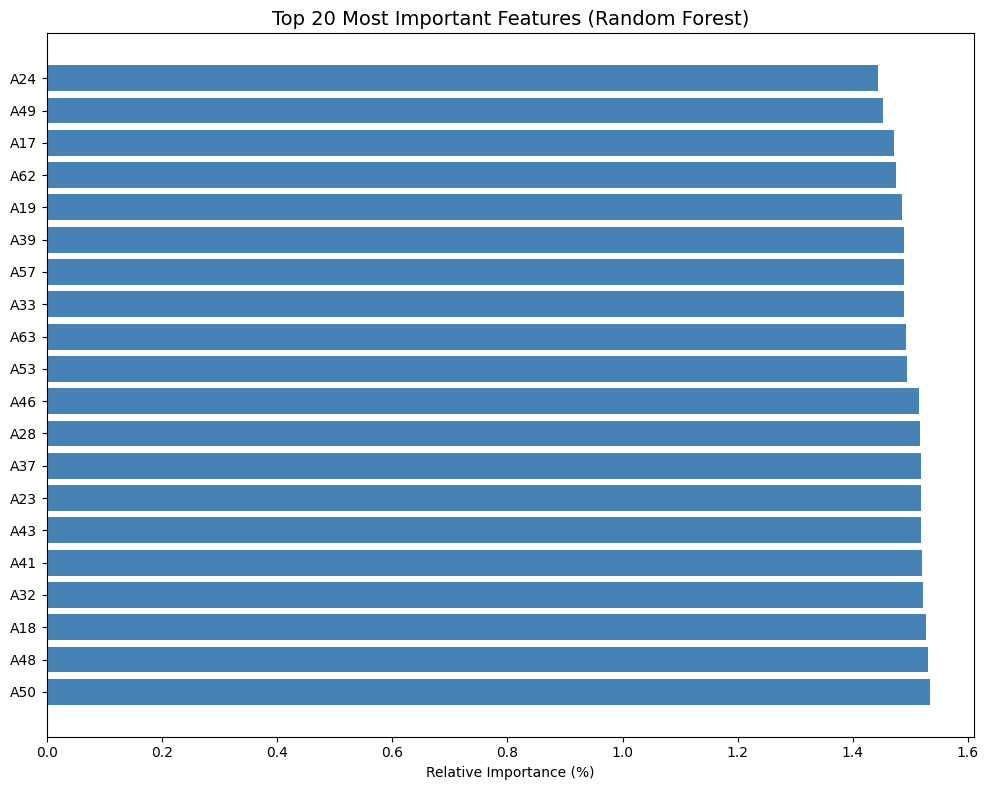

In [12]:
#plot the feature importance using matplot lib
# Optional: Show only top 20 features
top_n = 20
df_plot = df_importance.tail(top_n)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(df_plot['Band'], df_plot['Relative Importance (%)'], color='steelblue')
plt.xlabel('Relative Importance (%)')
plt.title(f'Top {top_n} Most Important Features (Random Forest)', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

**6. Export the result in Google Drive**

In [14]:
export_task = ee.batch.Export.image.toDrive(
    image=lulc_map,
    description='Update_RF_LC_sat_embed',
    folder='Earth Engine',
    fileNamePrefix='Update_RF_LC_sat_embed',
    scale=10,
    region=image_2024.geometry(),  # or aoi.geometry()
    maxPixels=1e13
)
export_task.start()
import time

while export_task.active():
    print('Exporting... (status: {})'.format(export_task.status()['state']))
    time.sleep(10)

print('Export complete (status: {})'.format(export_task.status()['state']))

Exporting... (status: READY)
Export complete (status: FAILED)
